# Regression Test Case Selection Using Machine Learning

# Introduction

**Abstract** : 

Regression testing is the common task of retesting software that has been changed or extended by new features during software development. And most of the time retesting the whole program is not feasible with reasonable time and cost, and to overcome only a subset of all test cases is executed for regression testing, e.g., by executing test cases according to test case prioritization.

There are a vast amount of methods for test case selection exist but mostly it is a based on domain expertise of Test Engineers/Subject Matter Expert.As obvious, this manual process is time consuming, iterative and largely depends upon the engineer's skills which mean there are high chances of missing some relevant test cases.

**Propsed Solution** : 

In this Proof of Concept (**POC**), we will select test cases for manual regression testing with the help of Classification Learning Model.

Our approach considers meta data related to test cases and Natural Language test case descriptions as an input to classification learning models to predict selection of test cases. 

Below image will summarize the proposed solution

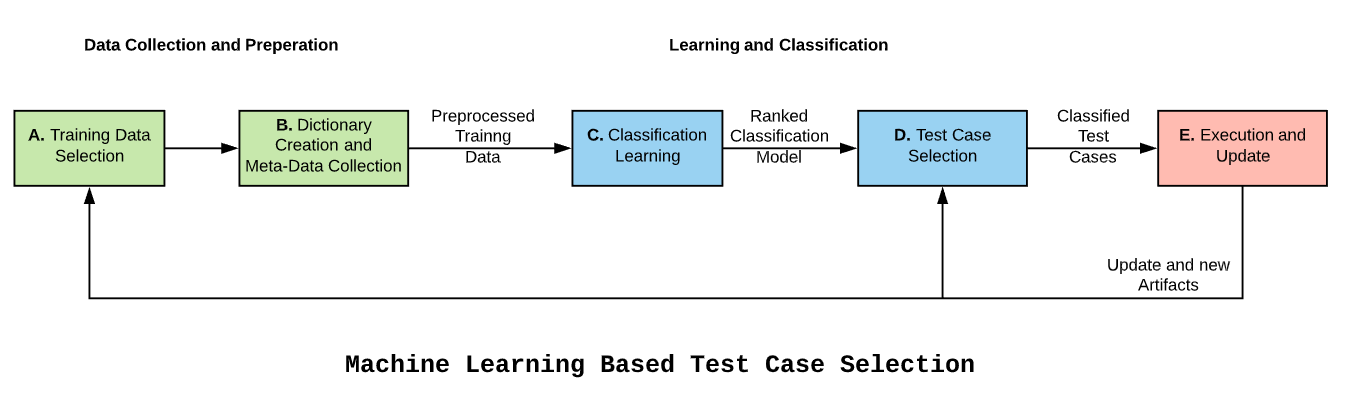

# Data Collection and Preparation

For POC we have considered **AuthZ**  microservices Test cases across four release cycles as our Test Data.

AuthZ is an authorization microservice for HP Cloud Print Paltform, it is based on Oauth2 standard which is widely used in industry for authorization across systems/microservices. Refer this [link](https://oauth.net/about/introduction/) for more information on Oauth2


Before going forward let's understand how currently test selection process is happening in HP Cloud Print Platform

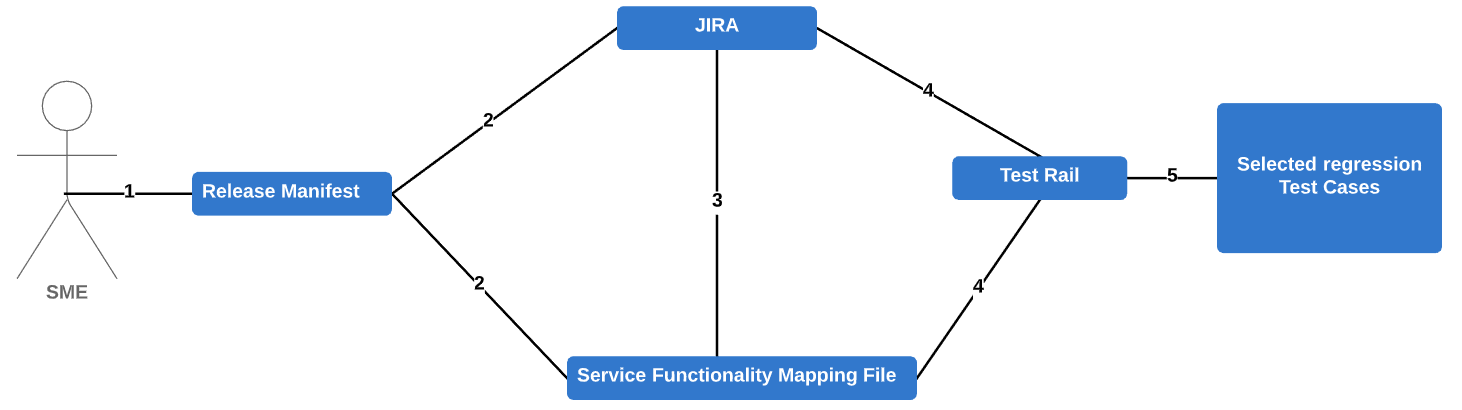

                                              
> **Release Manifest:** It is collection of versioned stuff that is being deployed, configuration settings, and issues/stories/artifacts description which are going to be deployed in particular release

> **JIRA:** Agile Project Management and Bug Tracking Tool

> **Service Functionality Mapping File:** Matrix which consists of mapping between Microservices and functionality , this will help users to understand impacted area when particular microservice getting affected

> **Test Rail:** Test Management Tool

Let's understand the process step by step

**Step 1:** For every release Subject Matter Expert(**SME**) refer Release Manifest to understand which microservices are under test and details of the fixes/commits in that particular release 

**Step 2:** SME will take stories and Bug ID's from Release Manifest and navigate to JIRA to get more relevant details , also based on the domain knowledge SME will refer Service Functionality Mapping File to understand impacted functionality

**Step 3:** Based on the information from JIRA ,SME will again refer Service Functionality Mapping File to get the list of impacted fucntionality

**Step 4:** Based on the impacted functionality list from above two steps SME will now navigate to Test Rail to search relevant test cases

**Step 5:** With the help of domain knowledge and data collected from above steps SME will select the list of test cases from Test Rail

Let's take a quick look at test data which consists of regression test cases across four release cycles

In [211]:
#importing required libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [224]:
#Importing test case dump
dataset=pd.read_csv("TestCases_TestData.csv")

In [213]:
#Checking the number of records and columns
dataset.shape

(664, 12)

In [214]:
#Checking data set
dataset.head()

,Id,ReleaseID,Type of Test Case,TestCaseTitle,TestCaseDescription,Error Prone Test Cases,Automation Status,Any Defect,JIRA Bug ID,Bug Description,GIT Commit Message,Target
0,1,R20.2.1,Sanity,Get the short and detailed health status APIs,When I call short health status API\n T...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh,1
1,2,R20.2.1,Sanity,Get the AuthZ service metadata,When I call metadata data API\n Then Respon...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh\nOpenId Metadata...,1
2,3,R20.2.1,Sanity,Get the public keys for validating token,When I call GET Json web keys discovery API\r\...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh,1
3,4,R20.2.1,API/Functionality,Verify Client delegation API: Exchange Access ...,Given I have a valid access token generated ...,Yes,Yes,No,NaN,NaN,NaN,1
4,5,R20.2.1,API/Functionality,Verify Client delegation API:Exchange Access t...,Given I have a valid access token generated fr...,No,Yes,No,NaN,NaN,NaN,1


Let's understand the columns/features present in dataset

<a>**ID**</a>: Unique Identifier of Records

<a>**ReleaseID**</a> : Release Identification number , Ex: **R20.2.1** stands for 'First release of 2 month of Year 2020

<a>**Type of Test Case**</a> : Cateogarization of Test cases , Ex: 'Sanity' test cases are supposed to be executed for Sanity of microservice and 'API/Functionality' test cases are for core functionality of microservice
    
<a>**Test Case Description**</a> : Steps for a test cases in Behavior Driven Devlopment(BDD) format

<a>**Error Prone Test Cases**</a> : Test cases which are covering high error prone area , these test cases must be executed in every release

<a>**Automation Status**</a> : Wheather test case is automated or not

<a>**Any Defect**</a> : If there is any defect in the release manifest then it will be mapped to the corresponding/relevant test cases and this column will be marked as 'Yes'

<a>**JIRA Bug ID**</a> : Corresponding Bug ID of JIRA

<a>**Bug Description**</a> : JIRA Title/description of corresponding bug

<a>**GIT Commit Message**</a> : For particular release , if there are any commits in GIT then the corresponding/relevant test cases and this column will be marked with commit messages

<a>**Target**</a> : Binary classification of Test Cases selection

> **It's quite possible that in actual , SME/Test Engineer is not considering above features/columns for test cases selection. But we strongly believe that these features should be considered during test case selection as they are directly or indirectly impacting Release and Qualification Cycles**

**Exploratory Data Analysis**:

Let's explore these features one by one and it's impact on target variable , in other words let's try to understand how these features are related to selection of test cases. This analalysis will eventually help us in training our classifier model.


Let's start with **Categorical Variables** ,will begin with **ReleaseID**.

We will check that how test cases are selected across different releases

In [215]:
#Getting unique value of releaseID column
dataset['ReleaseID'].unique()

array(['R20.2.1', 'R20.1.2', 'R20.1.1', 'R19.12.1'], dtype=object)

In [216]:
#Getting unique count for each release
dataset['ReleaseID'].value_counts()

R20.1.2     166
R20.1.1     166
R20.2.1     166
R19.12.1    166
Name: ReleaseID, dtype: int64

Test data comprise of four different releases and for each release there are equal number of test cases , but not all of them are selected for execution.

Let's visualize that how many test cases selection is happening across release

In [217]:
#Creating Dictonary for Release ID and selected and not selected test cases
selectedTCRelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Target'] == 1)].index)),
                        'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Target'] == 1)].index)),
                        'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Target'] == 1)].index)),
                        'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Target'] == 1)].index))}
nonselectedTCRelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Target'] == 0)].index)),
                           'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Target'] == 0)].index)),
                           'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Target'] == 0)].index)),
                           'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Target'] == 0)].index))}

#Converting Data Dictonary to series
selectedTCRelease_series=pd.Series(selectedTCRelease_dict)
nonselectedTCRelease_series=pd.Series(nonselectedTCRelease_dict)

#Visualizing selecting test cases per Release
fig = go.Figure(data=[
    go.Bar(name='Selected Test Cases', x=selectedTCRelease_series.index, y=selectedTCRelease_series.values),
    go.Bar(name='Not Selected Test Cases',  x=nonselectedTCRelease_series.index, y=nonselectedTCRelease_series.values)
])
# Change the bar mode
fig.update_layout(
    title="Release Wise Test Case Selection",
    xaxis_title="Releases",
    yaxis_title="Number of Test Cases",
    barmode='group',
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show()

It's evident that selection of test cases is not uniform across the release and which is obvious , but we need to identify that what are the fetaures which play role in test case selection.

Let's see how defects are mapped across releases

In [218]:
#Creating Dictonary for Release ID and bugs in that particular Release
bugsInrelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Any Defect'] == 'Yes')].index))}
#Converting Data Dictionary into Series
bugsInrelease_series=pd.Series(bugsInrelease_dict)
#Visualizing Bugs per releases
fig = px.bar(bugsInrelease_series, x=bugsInrelease_series.values, y=bugsInrelease_series.index,orientation='h')
# Change the bar mode
fig.update_layout(
    title="Number of Bugs Per Releases",
    xaxis_title="Number of Bugs",
    yaxis_title="Releases",   
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show()


In R20.1.1 release there are **18** bugs and in R20.2.1 release there are **3** bugs , from the previous graph we can say that maximum number of selected test cases are in these two releases only . 

With this analysis we can say that **Any Defect** feature is playing role in selection of test case.

Now let's start exploring column **Error Prone Test Cases** 

In [233]:
print("Number of Error Prone Test Cases in R20.2.1 release are {} ".format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes')
                                                                                       & (dataset['ReleaseID']=='R20.2.1')].index)))
print("Number of Error Prone Test Cases in R20.1.2 release are {} ".format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes') 
                                                                                       & (dataset['ReleaseID']=='R20.1.2')].index)))
print("Number of Error Prone Test Cases in R20.1.1 release are {} ".format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes') 
                                                                                       & (dataset['ReleaseID']=='R20.1.1')].index)))
print("Number of Error Prone Test Cases in R19.12.1 release are {} ".format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes')
                                                                                        & (dataset['ReleaseID']=='R19.12.1')].index)))

Number of Error Prone Test Cases in R20.2.1 release are 13 
Number of Error Prone Test Cases in R20.1.2 release are 13 
Number of Error Prone Test Cases in R20.1.1 release are 13 
Number of Error Prone Test Cases in R19.12.1 release are 13 


Number of Error Prone Test Cases is same in all release , on closer look it seems to be obvious because every release have similar set of test cases and these cases will be marked as 'Error Prone' based on domain expertise of SME.

Let's see how these test cases are selected

In [234]:
print("Number of Not Selected Error Prone Test Cases are {} ".format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes')
                                                                                 & (dataset['Target']=='No')].index)))

Number of Not Selected Error Prone Test Cases are 0 


This means all Error Prone Test cases from each release are selected for executed , it means these cases are **must executed** test cases and this feature directly respobsible for selecting test cases

Let's put our focus on another features **Automation Status** and **Type of Test Case**

In [ ]:
sns.catplot(x='Re')

Let's create Corpus from 'TCD' coloumn, **Corpus** is a simplified version of our test case description data that contain clean text data. 

To create Corpus we have to perform the following actions

<ol>
    <li><b>Remove unwanted words</b>: Removal of unwanted words such as <a>special characters</a> and <a>numbers</a> to get only pure text. We will do it by specify our pattern using re library</li>
    <li><b>Transform words to lowercase</b>: Transform words to lowercase because upper and lower case have diffirent <a>ASCII</a> codes</li>
    <li><b>Remove stopwords</b>:Stop words are usually the most common words in a language and they will be irrelevant in determining the nature</li>
    <li><b>Stemming words</b>:Stemming is the process of reducing words to their word stem, base or root form. We use stemming to reduce Bag of Words dimensionality</li>
</ol>  

Now let's deal with our **TCD** column.

In [5]:
corpus  = []
pstem = PorterStemmer()
for i in range(dataset['TCD'].shape[0]):
    #Remove unwanted words
    text = re.sub("[^a-zA-Z]", ' ', dataset['TCD'][i])
    #Transform words to lowercase
    text = text.lower()
    text = text.split()
    #Remove stopwords then Stemming it
    text = [pstem.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    #Append cleaned tweet to corpus
    corpus.append(text)
    
print("Corpus created successfully") 

Corpus created successfully


In [6]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# Learning and Classification
Now we will build our models, we will use following models
* Gaussian Naive Bayes Model
* Multinomial Naive Bayes Model
* Decision Tree Model
* Gradient Boosting Model
* K - Nearest Neighbors Model

We will evaluate model based on confusion matrix , which is formed from the four outcomes produced as a result of binary classification

A binary classifier predicts all data instances of a test dataset as either positive or negative. This classification (or prediction) produces four outcomes – true positive, true negative, false positive and false negative.

* True positive (TP): correct positive prediction
* False positive (FP): incorrect positive prediction
* True negative (TN): correct negative prediction
* False negative (FN): incorrect negative prediction

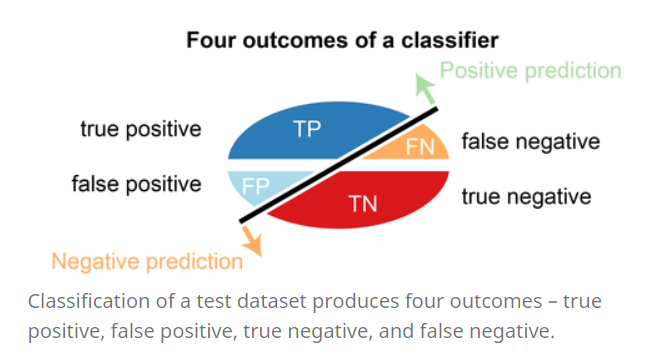

## Confusion matrix
A confusion matrix of binary classification is a two by two table formed by counting of the number of the four outcomes of a binary classifier. We usually denote them as TP, FP, TN, and FN instead of “the number of true positives”, and so on

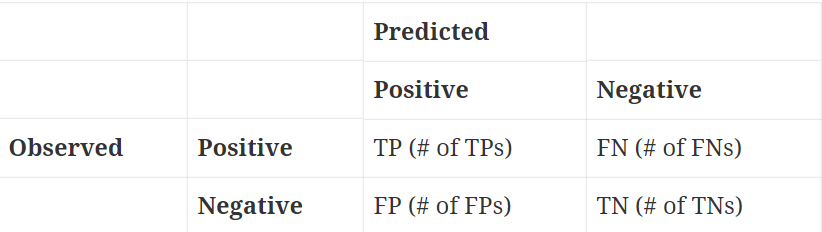

## Error Rate

Error rate (ERR) is calculated as the number of all incorrect predictions divided by the total number of the dataset. The best error rate is 0.0, whereas the worst is 1.0

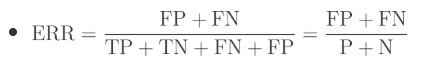

## Accuracy
Accuracy (ACC) is calculated as the number of all correct predictions divided by the total number of the dataset. The best accuracy is 1.0, whereas the worst is 0.0. It can also be calculated by 1 – ERR

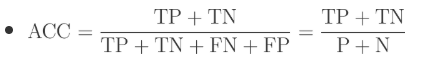

## F1 Score

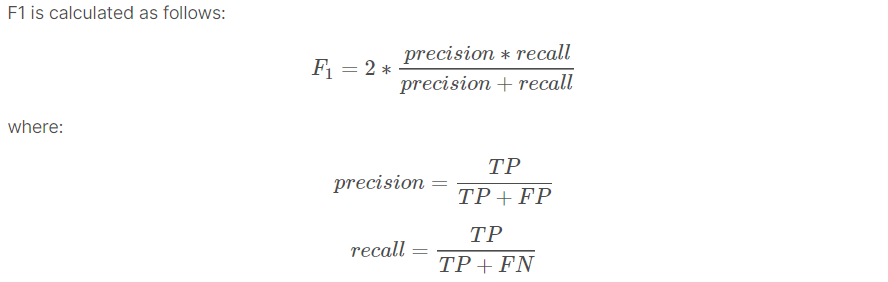

In [7]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Gaussian Naive Bayes Model

In [8]:
# Fitting Gausian to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_gnb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
cm_gnb

array([[180,  49],
       [  5, 192]], dtype=int64)

In [9]:
#Calculating Model Accuracy
print('GaussianNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gnb.score(X_train, y_train)))
print('GaussianNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gnb.score(X_test, y_test)))
print('GaussianNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gnb)))

GaussianNB Classifier Accuracy Score is 0.897119341563786 for Train Data Set
GaussianNB Classifier Accuracy Score is 0.8732394366197183 for Test Data Set
GaussianNB Classifier F1 Score is 0.8767123287671231


## Multinomial Naive Bayes Model

In [10]:
# Fitting Naive Bayes to the Training set
classifier_nb = MultinomialNB(alpha=0.1)
classifier_nb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_nb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

In [11]:
#Calculating Model Accuracy
print('MultinomialNB Classifier Accuracy Score is {} for Train Data Set'.format(classifier_nb.score(X_train, y_train)))
print('MultinomialNB Classifier Accuracy Score is {} for Test Data Set'.format(classifier_nb.score(X_test, y_test)))
print('MultinomialNB Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_nb)))

MultinomialNB Classifier Accuracy Score is 0.8659611992945326 for Train Data Set
MultinomialNB Classifier Accuracy Score is 0.8403755868544601 for Test Data Set
MultinomialNB Classifier F1 Score is 0.8767123287671231


## Decision Tree Model

In [12]:
# Fitting Decision Tree Model to the Training set
classifier_dt = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)
classifier_dt.fit(X_train, y_train)
# Predicting the Test set results
y_pred_dt = classifier_dt.predict(X_test)
# Making the Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

array([[217,  12],
       [ 16, 181]], dtype=int64)

In [13]:
#Calculating Model Accuracy
print('Decision Tree  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_dt.score(X_train, y_train)))
print('Decision Tree Classifier Accuracy Score is {} for Test Data Set'.format(classifier_dt.score(X_test, y_test)))
print('Decision Tree Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_dt)))

Decision Tree  Classifier Accuracy Score is 0.9970605526161082 for Train Data Set
Decision Tree Classifier Accuracy Score is 0.9342723004694836 for Test Data Set
Decision Tree Classifier F1 Score is 0.9282051282051282


## Gradient Boosting Model

In [14]:
# Fitting Gradient Boosting Model to the Training set
classifier_gb = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)
classifier_gb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_gb = classifier_gb.predict(X_test)
# Making the Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb

array([[212,  17],
       [ 13, 184]], dtype=int64)

In [15]:
#Calculating Model Accuracy
print('Gradient Boosting  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_gb.score(X_train, y_train)))
print('Gradient Boosting Classifier Accuracy Score is {} for Test Data Set'.format(classifier_gb.score(X_test, y_test)))
print('Gradient Boosting Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_gb)))

Gradient Boosting  Classifier Accuracy Score is 0.9964726631393298 for Train Data Set
Gradient Boosting Classifier Accuracy Score is 0.9295774647887324 for Test Data Set
Gradient Boosting Classifier F1 Score is 0.9246231155778896


## K - Nearest Neighbors Model

In [16]:
# Fitting K - Nearest Neighbors Model to the Training set
classifier_knn = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')
classifier_knn.fit(X_train, y_train)
# Predicting the Test set results
y_pred_knn = classifier_knn.predict(X_test)
# Making the Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[200,  29],
       [  7, 190]], dtype=int64)

In [17]:
#Calculating Model Accuracy
print('KNN  Classifier Accuracy Score is {} for Train Data Set'.format(classifier_knn.score(X_train, y_train)))
print('KNN Accuracy Score is {} for Test Data Set'.format(classifier_knn.score(X_test, y_test)))
print('KNN Classifier F1 Score is {}'.format(f1_score(y_test, y_pred_knn)))

KNN  Classifier Accuracy Score is 0.9970605526161082 for Train Data Set
KNN Accuracy Score is 0.9154929577464789 for Test Data Set
KNN Classifier F1 Score is 0.9134615384615384


# What's Next? - To Do's

- [ ] List of Features can be improved to train our model i.e for Metadata for test cases can be added like **Requirement Coverage** , **Failure Priority** , **Failure Age** , **Test Execution Cost**
- [ ] Add Validation data also along with test and train data
- [ ]  Can add Ensembling and Stacking of models to for better model training
- [ ] Can take Subject Matter Expert's help for accurate **Target** column values which finally help in model training
- [ ]  Convert the code base to utility script to work with **Test Rail** for better ease of use
- [ ] Currently couple of classifier models are coming as close to 93% accuracy , but this may differ for different data set so with new data set again we need to check the model's efficiency